In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
image_path='/content/drive/MyDrive/Datasets/train (1).zip'

In [4]:
from zipfile import ZipFile
with ZipFile(image_path, 'r') as z:
  z.extractall()

In [5]:
import os
import cv2

X=[]

# list all folders inside train directory
for i in os.listdir('train'):
      # read each image inside train directory one by one
      dummy = cv2.imread('train/' + i)
      dummy = cv2.resize(dummy, (64,64))
      X.append(dummy)

In [6]:
labels=[]
for dirname,_, filenames in os.walk('train'):
    for filename in filenames:
        label=filename.split('.')[0]
        labels.append(label)

In [7]:
len(X)

25000

In [8]:
labels[:11]

['dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'cat', 'dog', 'dog', 'cat']

In [9]:
rand=np.random.randint(0,len(X),12)

In [10]:
print(rand)

[11908  6102 15728  2347 12261 17188  5873  9661   962 16579 22085 10855]


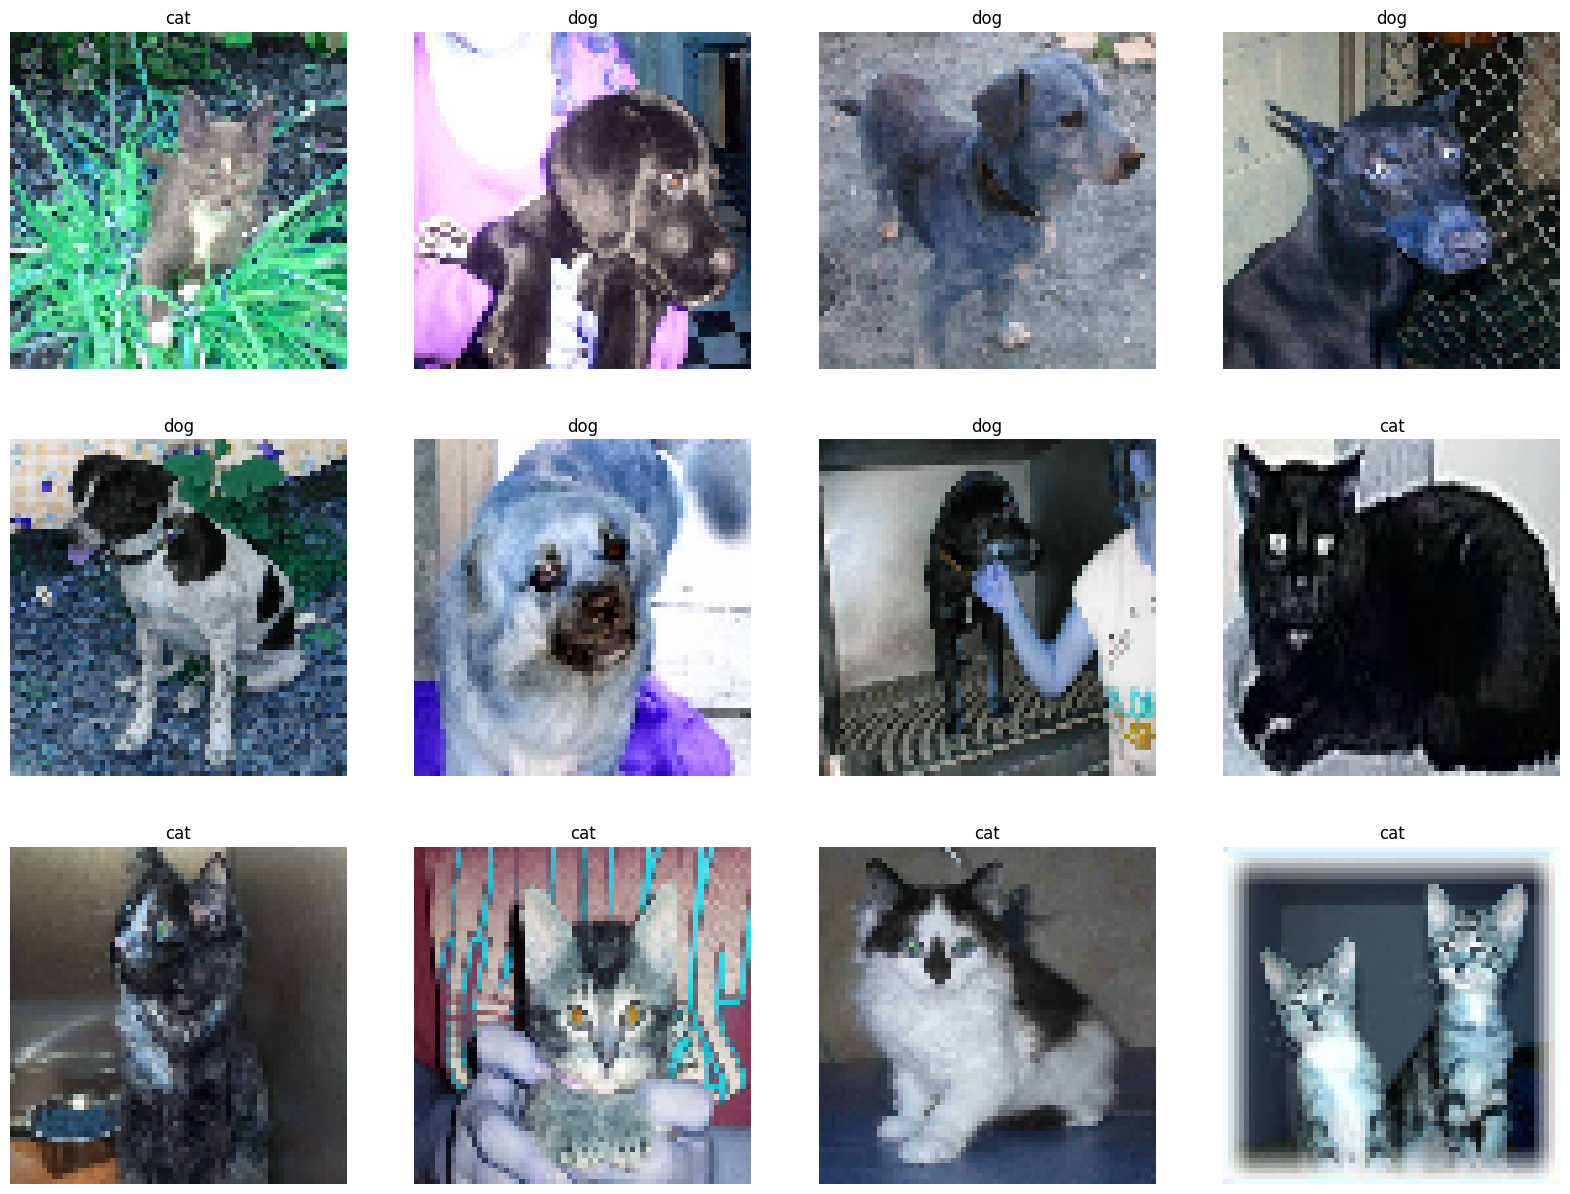

In [11]:
plt.figure(figsize=(20, 15))
for i,j in enumerate(rand):
  plt.subplot(3,len(rand)//3,i+1)
  plt.imshow(X[j])
  plt.title('{}'.format(labels[j]))
  plt.axis('off')

plt.show()

In [12]:
X = np.array(X)
labels = np.array(labels)

In [13]:
from sklearn.model_selection import train_test_split
X_train,X_val,Y_train,Y_val=train_test_split(X,labels,test_size=0.3,random_state=42)

In [14]:
Y_train = pd.get_dummies(Y_train).values
Y_val = pd.get_dummies(Y_val).values

In [15]:
X_train=X_train.astype('float')
X_train=X_train/255
X_val=X_val.astype('float')
X_val=X_val/255

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D, Dropout, Dense, Flatten, BatchNormalization, MaxPooling2D

In [17]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

base_model = VGG19(input_shape=X_train[0].shape,
                   weights='imagenet',
                   include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
x = BatchNormalization()(x)
x = Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
x = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
x = BatchNormalization()(x)
preds = Dense(2, activation='softmax')(x)

model2_vgg19 = Model(inputs=base_model.input, outputs=preds)

for layer in model2_vgg19.layers[:20]:
    layer.trainable = False
for layer in model2_vgg19.layers[20:]:
    layer.trainable = True

# Learning Rate Scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Compile the model
model2_vgg19.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

model2_vgg19.summary()

80134624/80134624 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                              

In [18]:
history = model2_vgg19.fit(datagen.flow(X_train, Y_train, batch_size=32),
                          validation_data=(X_val,Y_val),
                          epochs=50)

Epoch 1/50
547/547 [==============================] - 49s 73ms/step - loss: 0.8736 - accuracy: 0.6439 - val_loss: 0.7413 - val_accuracy: 0.7147
Epoch 2/50
547/547 [==============================] - 38s 69ms/step - loss: 0.7765 - accuracy: 0.6994 - val_loss: 0.7242 - val_accuracy: 0.7329
Epoch 3/50
547/547 [==============================] - 37s 67ms/step - loss: 0.7381 - accuracy: 0.7173 - val_loss: 0.6971 - val_accuracy: 0.7467
Epoch 4/50
547/547 [==============================] - 38s 69ms/step - loss: 0.7175 - accuracy: 0.7311 - val_loss: 0.6631 - val_accuracy: 0.7633
Epoch 5/50
547/547 [==============================] - 38s 69ms/step - loss: 0.6991 - accuracy: 0.7410 - val_loss: 0.6567 - val_accuracy: 0.7640
Epoch 6/50
547/547 [==============================] - 35s 64ms/step - loss: 0.6828 - accuracy: 0.7506 - val_loss: 0.6616 - val_accuracy: 0.7620
Epoch 7/50
547/547 [==============================] - 35s 64ms/step - loss: 0.6788 - accuracy: 0.7506 - val_loss: 0.6707 - val_accuracy:

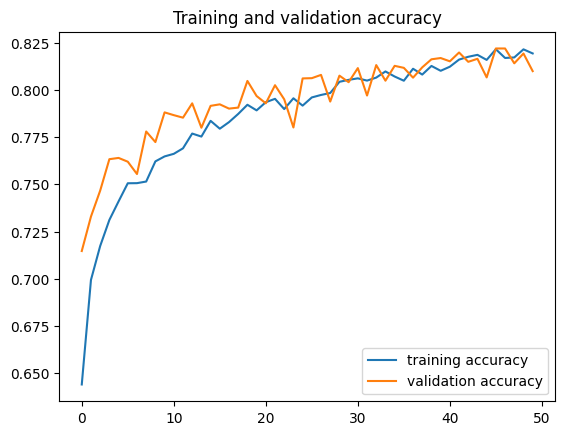

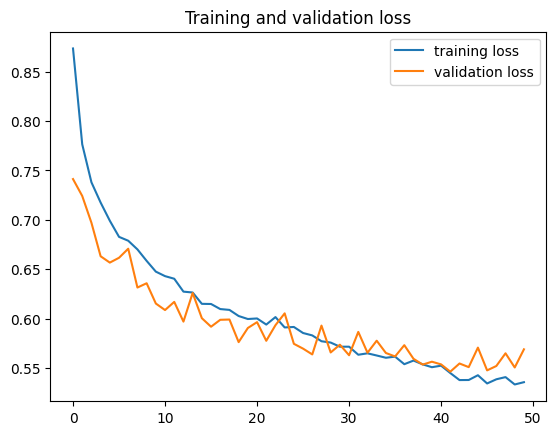

In [19]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy)) # Get number of epochs

plt.plot(epochs, accuracy, label = 'training accuracy')
plt.plot(epochs, val_accuracy, label = 'validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc = 'lower right')
plt.figure()

plt.plot(epochs, loss, label = 'training loss')
plt.plot(epochs, val_loss, label = 'validation loss')
plt.legend(loc = 'upper right')
plt.title('Training and validation loss')
plt.show()